## Timing our algorithms

In [51]:
import time, random
import pandas as pd
import seaborn as sns
import matplotlib as plt
import sys

In [52]:
import parsers, timing_search, gen_lcp

In [53]:
def dna(length=int(), letters="CGTA"):
    return''.join(random.choices(letters, k=length))

def create_one_fasta(n):
    name = f"test_files/n_{n}.fasta"
    f = open(name, "w")
    
    f.write('>Seq' + str(1) + '\n' + dna(n) + '\n')
    
    f.close()

    return name

def create_many_fasta(start, stop, step):
    name = f"test_files/n_{stop}.fasta"
    f = open(name, "w")
    counter = 1

    for i in range(start, stop, step):
        f.write('>Seq' + str(counter) + '\n' + dna(i) + '\n')
        counter += 1
    f.close()

    return name

def create_one_fastq(m):
    name = f"test_files/m_{m}.fastq"
    f = open(name, "w")
    f.write(
        '@' + 'Seq' + str(1) + '\n' + 
        dna(m) + '\n' + 
        '+' + '\n' + 
        '~' * m + '\n')
    f.close()
    
    return name

def create_many_fastq(start, stop, step):
    name = f"test_files/m_{stop}.fastq"
    f = open(name, "w")

    counter = 1

    for i in range(start, stop, step):
        f.write(
            '@' + 'Seq' + str(counter) + '\n' + 
            dna(i) + '\n' + 
            '+' + '\n' + 
            '~' * i + '\n'
        )
        counter += 1
    
    f.close()
    
    return name


In [4]:
def time_construction(n): # THAT'S FOR gen_lcp, WE ARE NOT INTERESTED IN THAT
    df = pd.DataFrame(range(20, n, int(n/10)), columns=['n'])
    fasta_file = create_many_fasta(20, n, int(n/10))

    fasta = parsers.read_fasta_file(fasta_file)
    times = []

    if len(fasta) < 0:
        return "Problems with fasta file"

    for x in fasta.items():
        tree = None
        start = time.time()

        tree = gen_lcp.SuffixTree()
        tree.root.children = [None, None, None, None, None]
        seq = x[1]
        tree.insert(seq)
        SA, LCP = gen_lcp.SA_LCP(tree.root, SA=[], LCP=[])
        
        end = time.time()
        difference = end - start
        times.append(difference)

    
    df['Time'] = times

    df['Time/Expected time'] = df['Time']/df['n']
    return df

In [133]:
n = 100000
m = 1000

In [134]:
df_construction = time_construction(n)

Text(0.5, 1.0, 'Suffix tree construction')

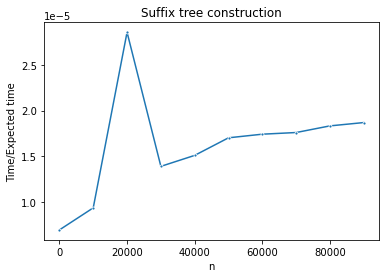

In [135]:
h = sns.lineplot(x = 'n', y = 'Time/Expected time', marker = '.',
                    data = df_construction)
h.set_title('Suffix tree construction')
#h.figure.savefig('../figures/search_st.pdf')

In [16]:
def time_construction(n, m): # Suffix tree construction using search_st2.py.
    df = pd.DataFrame(range(20, n, int(n/10)), columns=['n'])
    fastq_file = create_one_fastq(m)

    fastq = parsers.read_fastq_file(fastq_file) # fastq file with seq of len m
    sa_lcp = parsers.read_SA_LCP("SA_LCP.txt")  # txt file with SA and LCP of sequences created by 
                                                # create_many_fasta(20, n, int(n/10)) where n = 100000 and then ran with
                                                # search_st.py -p separately to create SA_LCP.txt file
    times = []

    if len(sa_lcp) < 0 or len(fastq) < 0:
        return "Problems with either sa_lcp or fastq file"

    flag, mapq, pnext, tlen = 0,0,0,0
    rnext = "*"


    for x in sa_lcp.items():
        rname = x[0]
        tree = None
        start = time.time()
        
        tree = timing_search.SuffixTree2()
        tree.root.children = []
        y = x[1][0] + "0"
        tree.seq, tree.alpha = timing_search.remap(y)
        sa = x[1][1]
        lcp = x[1][2]
        tree.lcp_suffix_tree(sa, lcp)
        
        end = time.time()
        difference = end - start
        times.append(difference)


        for p in fastq.items():
            qname = p[0]
            substring = p[1][0]
            cigar = str(len(substring)) + "M"
            qual = p[1][1]

            seq = [tree.alpha[a] for a in substring]

            matches = tree.search_rec(tree.root, 0, 0, seq)

            if matches is not None:
                for match in matches:
                    pos = int(match) + 1
                    print(f"{qname}\t{flag}\t{rname}\t{pos}\t{mapq}\t{cigar}\t{rnext}\t{pnext}\t{tlen}\t{substring}\t{qual}", file = sys.stdout)
    
    df['Time'] = times

    df['Time/Expected time'] = df['Time']/df['n']
    return df

In [45]:
n = 100000
m = 1000
df_construction = time_construction(n, m)
print(df_construction)

       n      Time  Time/Expected time
0     20  0.000083            0.000004
1  10020  0.039995            0.000004
2  20020  0.316066            0.000016
3  30020  0.190744            0.000006
4  40020  0.291525            0.000007
5  50020  0.421927            0.000008
6  60020  0.493989            0.000008
7  70020  0.634248            0.000009
8  80020  0.641045            0.000008
9  90020  0.791751            0.000009


Text(0.5, 1.0, 'Suffix tree construction')

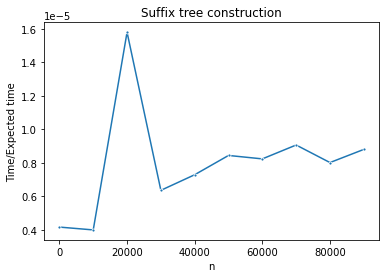

In [46]:
h = sns.lineplot(x = 'n', y = 'Time/Expected time', marker = '.',
                    data = df_construction)
h.set_title('Suffix tree construction')
#h.figure.savefig('figures/construction_search_st2.pdf')

In [21]:
fasta_file_1seq = create_one_fasta(100000)

In [54]:
def time_search(n, m): #Search using search_st2.py
    df = pd.DataFrame(range(20, m, int(m/10)), columns=['m'])
    fastq_file = create_many_fastq(20, m, int(m/10))

    fastq = parsers.read_fastq_file(fastq_file) # fastq file with multiple sequences of length 20 to m in steps of m/10
    sa_lcp = parsers.read_SA_LCP("SA_LCP_1.txt")# txt file with SA and LCP of a sequence created by 
                                                # create_one_fasta(n) where n = 100000 and then ran with
                                                # search_st.py -p separately to create SA_LCP.txt file

    times = []

    if len(sa_lcp) < 0 or len(fastq) < 0:
        return "Problems with either sa_lcp or fastq file"

    flag, mapq, pnext, tlen = 0,0,0,0
    rnext = "*"

    for x in sa_lcp.items():
        rname = x[0]
        tree = None
        tree = timing_search.SuffixTree2()
        tree.root.children = []
        y = x[1][0] + "0"
        tree.seq, tree.alpha = timing_search.remap(y)
        sa = x[1][1]
        lcp = x[1][2]
        tree.lcp_suffix_tree(sa, lcp)


        for p in fastq.items():
            start = time.time()
            qname = p[0]
            substring = p[1][0]
            cigar = str(len(substring)) + "M"
            qual = p[1][1]

            seq = [tree.alpha[a] for a in substring]

            matches = tree.search_rec(tree.root, 0, 0, seq)

            if matches is not None:
                for match in matches:
                    pos = int(match) + 1
                    print(f"{qname}\t{flag}\t{rname}\t{pos}\t{mapq}\t{cigar}\t{rnext}\t{pnext}\t{tlen}\t{substring}\t{qual}", file = sys.stdout)
            
            end = time.time()
            difference = end - start
            times.append(difference)

    df['Time'] = times

    df['Time/Expected time'] = df['Time']/df['m']

    return df

In [55]:
n = 100000
m = 1000
df_search = time_search(n, m)
print(df_search)

     m      Time  Time/Expected time
0   20  0.000032        1.609325e-06
1  120  0.000026        2.165635e-07
2  220  0.000035        1.593070e-07
3  320  0.000035        1.087785e-07
4  420  0.000044        1.050177e-07
5  520  0.000047        9.078246e-08
6  620  0.000052        8.383105e-08
7  720  0.000056        7.748604e-08
8  820  0.000065        7.908519e-08
9  920  0.000071        7.696774e-08


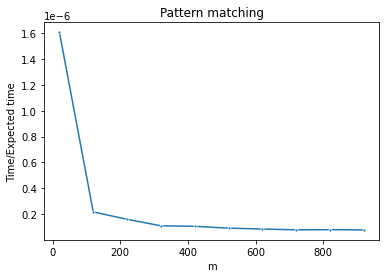

In [58]:
h = sns.lineplot(x = 'm', y = 'Time/Expected time', marker = '.',
                    data = df_search)
h.set_title('Pattern matching')
h.figure.savefig('figures/search_st2.pdf')